Imports

In [1]:
import pandas as pd
import numpy as np
import time
import re
import os
import pretty_midi
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gensim.downloader
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
from torch.utils.tensorboard import SummaryWriter
import optuna
import itertools
import librosa
import random


/home/liorkob/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-14 13:42:49.483731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load Word2Vec Model

In [2]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

# Load Data


In [3]:
train_set = pd.read_csv('/home/gorelikk/ASS3/lyrics_train_set.csv', header=None, usecols=[0, 1, 2])
train_set.columns = ['Artist', 'Song_name', 'Lyrics']
test_set = pd.read_csv('/home/gorelikk/ASS3/lyrics_test_set.csv', header=None, usecols=[0, 1, 2])
test_set.columns = ['Artist', 'Song_name', 'Lyrics']

# Data Analyze

In [4]:
def Lexical_Richness(data):
  data['Unique_Words'] = data['Lyrics'].apply(lambda x: len(set(x.split())))
  data['Total_Words'] = data['Lyrics'].apply(lambda x: len(x.split()))
  data['Lexical_Richness'] = data['Unique_Words'] / data['Total_Words']

  top_lexical_richness = data[['Artist', 'Song_name', 'Lexical_Richness']].sort_values(by='Lexical_Richness', ascending=False).head(10)

  # Plotting
  plt.figure(figsize=(10, 8))
  plt.barh(top_lexical_richness['Song_name'], top_lexical_richness['Lexical_Richness'], color='skyblue')
  plt.xlabel('Lexical Richness')
  plt.ylabel('Song Name')
  plt.title('Top 10 Songs by Lexical Richness')
  plt.gca().invert_yaxis()  
  plt.show()

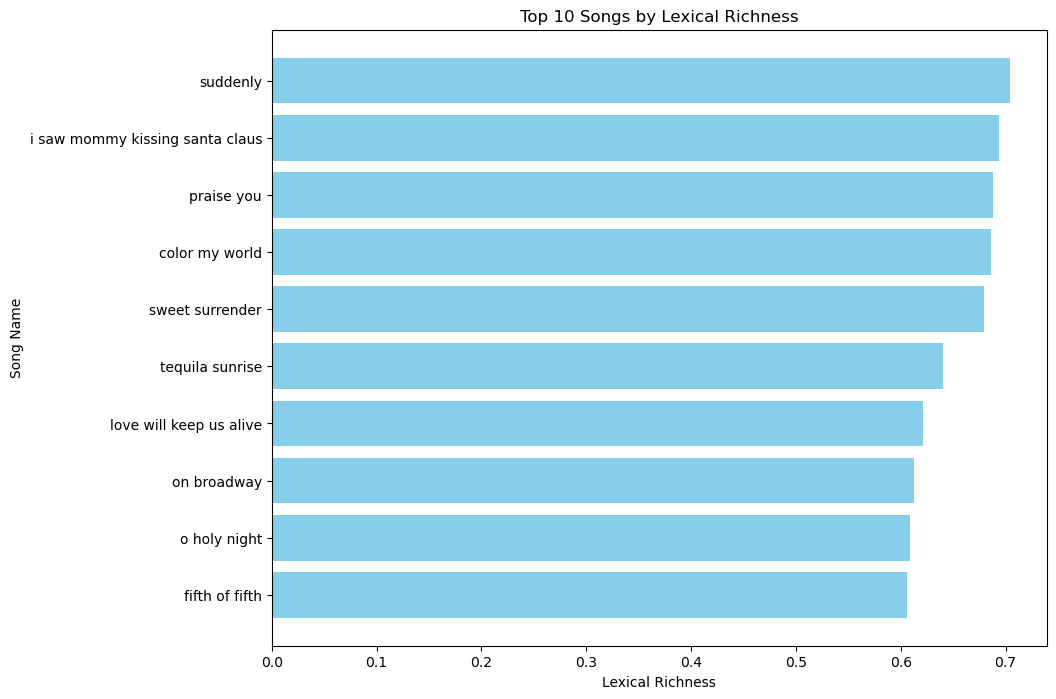

In [ ]:
Lexical_Richness(train_set)

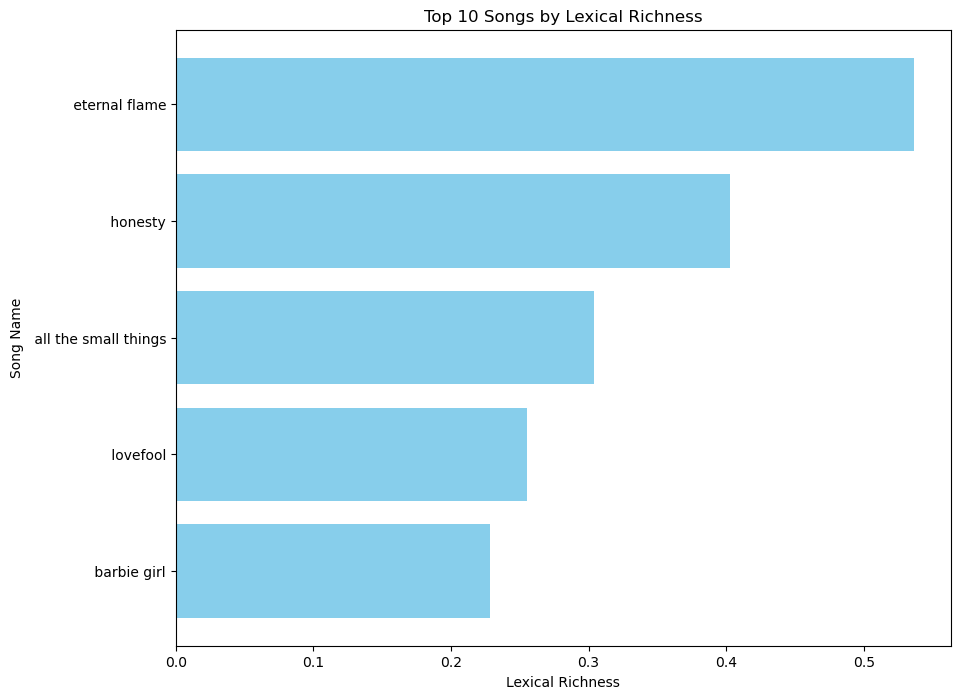

In [ ]:
Lexical_Richness(test_set)

Function to count words in lyrics


In [ ]:
def count_words(lyrics):
    return len(lyrics.split())

train_set['Word_Count'] = train_set['Lyrics'].apply(count_words)
test_set['Word_Count'] = test_set['Lyrics'].apply(count_words)

mean_word_count_train = train_set['Word_Count'].mean()
mean_word_count_test = test_set['Word_Count'].mean()

print(f"Average number of words per song in the Train Set: {mean_word_count_train:.2f}")
print(f"Average number of words per song in the Test Set: {mean_word_count_test:.2f}")

Average number of words per song in the Train Set: 299.48
Average number of words per song in the Test Set: 269.60


In [ ]:
num_artists_train = train_set['Artist'].nunique()
num_artists_test = test_set['Artist'].nunique()

print(f"Number of unique artists in the Train Set: {num_artists_train}")
print(f"Number of unique artists in the Test Set: {num_artists_test}")

Number of unique artists in the Train Set: 226
Number of unique artists in the Test Set: 5


# Create Vocabularies


In [4]:
vocab = set()
filters = '!"#$%()*+,&-./:;<=>?@[\\]^_`{|}~\t\n'
for lyrics in train_set.Lyrics.tolist():
    words = re.sub(f'[{filters}]', '', lyrics).split()
    vocab.update(words)
vocab.discard('')
vocab_size = len(vocab) + 1

word2index = {w: i for i, w in enumerate(vocab)}
index2word = {i: w for w, i in word2index.items()}

In [15]:
vocab_size

7537

Convert lyrics to indices


In [5]:
train_set['tokens'] = train_set['Lyrics'].apply(lambda x: [word2index.get(word, 0) for word in re.sub(f'[{filters}]', '', x).split()])
test_set['tokens'] = test_set['Lyrics'].apply(lambda x: [word2index.get(word, 0) for word in re.sub(f'[{filters}]', '', x).split()])

# Song Data Class


In [6]:
class SongDataset(Dataset):
    """
    A dataset class for handling song data, which includes lyrics and MIDI music features.
    
    Attributes:
        data (DataFrame): A pandas DataFrame containing song metadata and lyrics.
        midi_path (str): Directory path where MIDI files are stored.
        word2vec_model (dict): Pre-trained word2vec model for converting words to vectors.
        vocab (list or dict): Vocabulary used in the dataset.
        method (str): Specifies the method to extract features from MIDI files.
        word2index (dict): Dictionary mapping words to their indices.
        index2word (dict): Dictionary mapping indices back to words.
    """
    def __init__(self, data, word2vec_model, vocab, midi_path, method):
        """
        Initializes the SongDataset class with the provided parameters and preprocesses the lyrics data.
        
        Parameters:
            data (DataFrame): Song data.
            word2vec_model (dict): Word2Vec model for word vectorization.
            vocab (list or dict): Vocabulary list or dictionary.
            midi_path (str): Path to the folder containing MIDI files.
            method (str): Method to use for extracting MIDI features ('model1' or 'model2').
        """
        self.data = data
        self.midi_path = midi_path
        self.word2vec_model = word2vec_model
        self.vocab = vocab
        self.method = method
        self.data['Lyrics'] = self.data.apply(lambda row: self.filter_chars_from_lyrics(row['Lyrics']), axis=1)
        self.word2index = word2index
        self.index2word = index2word

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves an item by its index and processes it into model inputs.
        
        Parameters:
            idx (int): Index of the data point to retrieve.
            
        Returns:
            tuple: A tuple containing the input features and target labels for the model.
        """
        row = self.data.iloc[idx]
        artist, song_name, lyrics = row['Artist'], row['Song_name'], row['Lyrics']
        if self.method == 'model1':
            midi_f = self.features_model1(artist, song_name)
        elif self.method == 'model2':
            midi_f = self.features_model2(artist, song_name)
        word_vec, labels = self.find_tokens_vec(lyrics)
        inputs = torch.cat([word_vec, midi_f.repeat(word_vec.size(0), 1)], dim=-1)
        return inputs, labels

    def filter_chars_from_lyrics(self, lyrics):
        """Removes special characters from lyrics to simplify the text."""
        return re.sub(f'[{filters}]', '', lyrics)

    def features_model1(self, artist, song_name):
        """Extracts MIDI features using the first model approach."""
        midi_file = self.retrieve_midi(artist, song_name)
        try:
            midi = pretty_midi.PrettyMIDI(os.path.join(self.midi_path, midi_file))
            beats = midi.get_beats()
            notes = np.concatenate([np.array([[note.start, note.end, note.pitch, note.velocity]]) for instrument in midi.instruments for note in instrument.notes])
            midi_features = torch.from_numpy(np.concatenate([beats, notes.flatten()])).float()
        except Exception as e:
            midi_features = torch.zeros((113,), dtype=torch.float32)
        return midi_features

    def features_model2(self, artist, song_name):
        """Extracts MIDI features using the second model approach, including chroma and is_drum."""
        midi_file = self.retrieve_midi(artist, song_name)
        try:
            midi = pretty_midi.PrettyMIDI(os.path.join(self.midi_path, midi_file))
            features = []
            for instrument in midi.instruments:
                notes = instrument.notes
                beats = midi.get_beats()
                velocity = np.mean([note.velocity for note in notes])
                pitch = np.mean([note.pitch for note in notes])
                chroma = midi.get_chroma()
                chroma_mean = np.mean(chroma, axis=1) if chroma.size else np.zeros(12)
                is_drum = 1 if instrument.is_drum else 0
                features.extend([len(notes), np.mean(beats), velocity, pitch, is_drum])
                features.extend(chroma_mean.tolist())
            midi_features = torch.tensor(features).float()
            expected_length = 140  
            features += [0] * (expected_length - len(features))
            midi_features = torch.tensor(features).float()
        except Exception as e:
            midi_features = torch.zeros((140,), dtype=torch.float32)  # Adjust the size if necessary
        return midi_features


    def find_tokens_vec(self, lyrics):
        """Converts lyrics into vectors using the word2vec model and prepares labels."""
        vec, labels = [], []
        lyrics_tokens = self.filter_chars_from_lyrics(lyrics).split()
        lyrics_tokens = [word for word in lyrics_tokens if word]
        for word in lyrics_tokens:
            labels.append(self.word2index.get(word, 0))
            if word in self.word2vec_model:
                vec.append(self.word2vec_model[word])
            else:
                vec.append(np.zeros((300,)))
        vec = torch.tensor(vec, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        return vec, labels

    def retrieve_midi(self, artist, song_name):
        """Retrieves the MIDI file corresponding to the specified artist and song name."""
   
        artist = artist.lower().replace(' ', '_')
        song_name = song_name.lower().replace(' ', '_')
        file_name = f"{artist}_-{song_name}.mid"
        try:
            midi_file = next(filter(lambda x: x.lower() == file_name, os.listdir(self.midi_path)))
            return midi_file
        except StopIteration:
            print(f"Warning: No MIDI file found for {artist} - {song_name} in {self.midi_path}")
        return None
        # artist = artist.replace(' ', '_')
        # song_name = song_name.replace(' ', '_')
        # file_name = f"{artist}_-_{song_name}.mid"
        # midi_file = next(filter(lambda x: x.lower() == file_name, os.listdir(self.midi_path)))
        # return midi_file

Collate Function

In [7]:
def collate_fn(batch):
    """
    A custom collate function for batching song data, which includes padding sequences
    so that all inputs and labels in the batch have the same length.
    
    This function is typically used to prepare batches of data when using variable-length
    sequences in models that require input tensors of the same shape, such as RNNs.

    Parameters:
        batch (list of tuples): A list where each tuple contains inputs and labels for a single data point.
    
    Returns:
        tuple: Contains two tensors:
            inputs_padded (Tensor): The padded input features tensor.
            labels_padded (Tensor): The padded labels tensor.
    """
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    return inputs_padded, labels_padded

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model

In [9]:
class LSTMLyrics(nn.Module):
    """
    A deep learning model based on the LSTM (Long Short-Term Memory) architecture for sequence processing,
    particularly suitable for tasks like language modeling or any sequence prediction tasks.

    Attributes:
        first_lstm (nn.LSTM): The first LSTM layer that processes the input sequence.
        second_lstm (nn.LSTM): The second LSTM layer that further processes the sequence from the first LSTM layer.
        first_linear (nn.Linear): A linear transformation layer applied after the LSTM layers.
        second_linear (nn.Linear): The final linear layer that outputs predictions for each token in the sequence.
        dropout (nn.Dropout): Dropout layer to reduce overfitting by randomly setting a fraction of the input units to 0.
    """
    def __init__(self, input_size, hidden_size, vocab_size):
        """
        Initializes the LSTM model with two LSTM layers and two linear layers.

        Parameters:
            input_size (int): The number of input features per element in the sequence.
            hidden_size (int): The number of features in the hidden state of the LSTMs.
            vocab_size (int): The size of the vocabulary, defining the output dimension of the final linear layer.
        """
        super(LSTMLyrics, self).__init__()
        self.first_lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.second_lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.first_linear = nn.Linear(hidden_size, hidden_size)
        self.second_linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input, hidden=None, return_state=False):
        """
        Defines the forward pass of the model.

        Parameters:
            input (Tensor): The input sequence to the model.
            hidden (tuple, optional): The initial hidden state for the LSTM layers.
            return_state (bool, optional): Whether to return the hidden states along with the model's output.

        Returns:
            Tensor or (Tensor, tuple): The output from the final linear layer, and optionally the hidden states.
        """
        input = input.to(torch.float32)
        input = input.to(device)
        out, hidden = self.first_lstm(input, hidden)
        out, hidden = self.second_lstm(out, hidden)
        out = self.dropout(self.first_linear(out))
        logits = self.second_linear(out)
        if return_state:
            return logits, hidden
        else:
            return logits

EarlyStopping Class

In [10]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Initializes the EarlyStopping

        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
            if self.verbose:
                print(f'New best score ({val_loss:.6f}).')
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
            self.counter = 0


# Train Function

In [7]:
def train_model(train_dataloader, validation_dataloader, input_size, hidden_size, epochs, writer, device, vocab_size, learning_rate, optimizer_name):
    """
    Trains an LSTM model on provided training data and evaluates it on validation data.
    
    Parameters:
        train_dataloader (DataLoader): DataLoader for the training dataset.
        validation_dataloader (DataLoader): DataLoader for the validation dataset.
        input_size (int): Number of input features per element in the sequence.
        hidden_size (int): Number of features in the hidden state of the LSTM.
        epochs (int): Number of epochs to train the model.
        writer (SummaryWriter): TensorBoard writer for logging metrics.
        device (torch.device): Device (CPU or GPU) to run the training on.
        vocab_size (int): Size of the vocabulary, defining the output dimension of the final linear layer.
        learning_rate (float): Learning rate for the optimizer.
        optimizer_name (str): Name of the optimizer to use for training.

    Returns:
        nn.Module: The trained LSTM model.
    """
    train_loss, validation_loss = [], []
    model = LSTMLyrics(input_size, hidden_size, vocab_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate, weight_decay=0.01)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        for input_lyrics, labels in train_dataloader:
            lyrics = input_lyrics.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(lyrics)
            loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
            writer.add_scalar('Loss/Training', loss.item(), epoch)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for input_lyrics, labels in validation_dataloader:
                lyrics = input_lyrics.to(device)
                labels = labels.to(device)
                logits = model(lyrics)
                loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
                writer.add_scalar('Loss/Validation', loss.item(), epoch)
                validation_loss.append(loss.item())

        mean_train_loss = np.average(train_loss)
        mean_validation_loss = np.average(validation_loss)
        
        print(f"Training loss for epoch {epoch + 1}: {mean_train_loss}, Validation loss: {mean_validation_loss}")
        early_stopping(mean_validation_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        writer.add_scalar('Mean Loss/Training', mean_train_loss, epoch)
        writer.add_scalar('Mean Loss/Validation', mean_validation_loss, epoch)
        writer.add_scalars('Loss Comparison', {'Training': mean_train_loss, 'Validation': mean_validation_loss}, epoch)
    end_time = time.time()
    duraion = end_time - start_time
    print(f"Duration Time:{duraion}")
    return model


# Create datasets and dataloaders

In [11]:
def prepare_dataloader(df, batch_size, method):
    """
    Prepares a DataLoader for song data, which facilitates batch processing during model training or evaluation.
    
    Parameters:
        df (DataFrame): A pandas DataFrame containing the song data.
        batch_size (int): Number of data points to load per batch.
        method (str): Specifies the method to extract MIDI features used in the SongDataset.

    Returns:
        DataLoader: A DataLoader object that provides iterable over the dataset with specified batch size and shuffling.
    """
    dataset = SongDataset(df, word2vec, vocab, './new_mid', method=method)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return dataloader

train_df, val_df = train_test_split(train_set, test_size=0.1, shuffle=True)


# First Model Train

In [12]:
train_dataloader_1 = prepare_dataloader(train_df, 32, method='model1')
val_dataloader_1 = prepare_dataloader(val_df, 32, method='model1')
writer = SummaryWriter(log_dir='runs/first_approach')
model = train_model(train_dataloader_1, val_dataloader_1, 300 + 113, 128, 25, writer, device, vocab_size, 0.001,'Adam')
torch.save(model.state_dict(), 'model_method_1.pth')
writer.close()



KeyboardInterrupt



In [ ]:
%load_ext tensorboard

%tensorboard --logdir runs/first_approach


# Second Model Train

In [12]:
train_dataloader_2 = prepare_dataloader(train_df, 32, method='model2')
val_dataloader_2 = prepare_dataloader(val_df, 32, method='model2')

writer = SummaryWriter(log_dir='runs/Approach2')

model = train_model(train_dataloader_2, val_dataloader_2, 300 + 140, 128, 25, writer, device, vocab_size, 0.001,'Adam')
torch.save(model.state_dict(), 'model_method_2.pth')
writer.close()


Training loss for epoch 1: 8.829691648483276, Validation loss: 8.770934104919434
New best score (8.770934).
Training loss for epoch 2: 8.79765510559082, Validation loss: 8.770934104919434
Validation loss decreased (8.770934 --> 8.770934).
Training loss for epoch 3: 8.740614891052246, Validation loss: 8.770934104919434
Validation loss decreased (8.770934 --> 8.770934).
Training loss for epoch 4: 8.415206106085526, Validation loss: 7.409964561462402
Validation loss decreased (7.409965 --> 7.409965).
Training loss for epoch 5: 7.816450004992277, Validation loss: 7.409964561462402
Validation loss decreased (7.409965 --> 7.409965).
Training loss for epoch 6: 7.816450004992277, Validation loss: 7.409964561462402
Validation loss decreased (7.409965 --> 7.409965).
Training loss for epoch 7: 7.510769605636597, Validation loss: 6.47917111714681
Validation loss decreased (6.479171 --> 6.479171).
Training loss for epoch 8: 7.510769605636597, Validation loss: 6.47917111714681
Validation loss decrea

In [13]:
%load_ext tensorboard

%tensorboard --logdir runs/Approach2

Launching TensorBoard...

# Loading Model

In [12]:
def load_model(model_path, input_size, hidden_size, vocab_size):
    model = LSTMLyrics(input_size, hidden_size, vocab_size)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    return model

# Generate Lyrics

In [13]:
# Generate Song Function for Testing
def generate_song(model, first_word, midi_f, seq, train_dataset):
    output_sequence = []
    song_words = [first_word]
    hidden = None
    input_sequence = seq
    while len(output_sequence) < 200:
        logits, hidden = model(input_sequence, hidden, return_state=True)

        soft_tensor = torch.softmax(logits, dim=-1)
        next_word_idx = torch.multinomial(soft_tensor, num_samples=1).item()

        while next_word_idx == vocab_size - 1:  # To avoid padding index
            next_word_idx = torch.multinomial(soft_tensor, num_samples=1).item()

        song_words.append(train_dataset.index2word[next_word_idx])
        word_vector = train_dataset.find_tokens_vec(train_dataset.index2word[next_word_idx])[0]
        next_word = torch.cat([word_vector, midi_f], dim=1)
        input_sequence = torch.tensor(next_word, dtype=torch.float, device=device)
        hidden = tuple(h.detach() for h in hidden)  # Detach each hidden state
        output_sequence.append(next_word)
        if len(output_sequence) % 10 == 0:
            input_sequence = seq
            hidden = None

    song = "\n".join(" ".join(song_words[i:i+5]) for i in range(0, len(song_words), 5))
    return song


    print(song)

input_size_model1 = 300 + 113  
input_size_model2 = 300 + 140  
hidden_size = 128  

first_model = load_model("/sise/home/gorelikk/ASS3/model_method_1.pth", input_size_model1, hidden_size, vocab_size)
second_model = load_model("/sise/home/gorelikk/ASS3/model_method_2.pth", input_size_model2, hidden_size, vocab_size)

# Create the Test DataLoader for both approaches
test_dataset_model1 = SongDataset(test_set, word2vec, vocab, '/sise/home/liorkob/DL/midi_files/', method='model1')
test_dataloader_model1 = DataLoader(test_dataset_model1, batch_size=1, shuffle=True)

test_dataset_model2 = SongDataset(test_set, word2vec, vocab, '/sise/home/liorkob/DL/midi_files/', method='model2')
test_dataloader_model2 = DataLoader(test_dataset_model2, batch_size=1, shuffle=True)


# Prepare sequences and features for testing
test_seq_model1 = [lyrics[:, 0, :] for lyrics, _ in test_dataloader_model1]
test_seq_model2 = [lyrics[:, 0, :] for lyrics, _ in test_dataloader_model2]

test_data = [(artist, song) for artist, song in zip(test_set['Artist'], test_set['Song_name'])]
midi_features_model1, midi_features_model2 = [], []

for artist, song_name in test_data:
    midi_features_model1.append(test_dataset_model1.features_model1(artist, song_name).view(1, 113))
    features_model2 = test_dataset_model2.features_model2(artist, song_name)
    # Ensure features_model2 has the correct shape
    if features_model2.size(0) != 140:
        padded_features = torch.zeros(140, dtype=torch.float32)
        length = min(features_model2.size(0), 140)
        padded_features[:length] = features_model2[:length]
        features_model2 = padded_features
    midi_features_model2.append(features_model2.view(1, 140))






In [14]:
import random
from collections import Counter

# Set a fixed seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Store the randomly chosen word
random_initial_word = None

# Function to choose the initial word
def choose_initial_word(strategy, test_lyrics=None):
    global random_initial_word
    if strategy == "random":
        if random_initial_word is None:
            random_initial_word = random.choice(list(word2index.keys()))
        return random_initial_word
    elif strategy == "most_common":
        all_words = [word for tokens in train_set['tokens'] for word in tokens]
        word_counts = Counter(all_words)
        most_common_word = word_counts.most_common(1)[0][0]
        return index2word[most_common_word]
    elif strategy == "least_common":
        all_words = [word for tokens in train_set['tokens'] for word in tokens]
        word_counts = Counter(all_words)
        least_common_word = word_counts.most_common()[-1][0]
        return index2word[least_common_word]
    elif strategy == "test_lyrics" and test_lyrics is not None:
        return test_lyrics.split()[0]
    else:
        raise ValueError("Invalid strategy. Choose from 'random', 'most_common', 'least_common', or 'test_lyrics'.")

# Function to generate and print songs
def generate_and_collect_songs(model, model_num, midi_features, test_seqs, test_data, test_set, strategies):
    generated_lyrics = []
    for i in range(len(test_data)):
        test_lyrics = test_set.iloc[i]['Lyrics']
        for strategy in strategies:
            initial_word = choose_initial_word(strategy, test_lyrics)
            generated_song = generate_song(model, initial_word, midi_features[i], test_seqs[i], test_dataset_model1)
            generated_lyrics.append((test_data[i][1], test_data[i][0], model_num, strategy, initial_word, generated_song))
    return generated_lyrics

# Define the strategies
strategies = ["random", "most_common", "least_common", "test_lyrics"]

# Collect and print generated songs
def collect_and_print_all_songs():
    all_generated_lyrics = []

    # Generate Test Songs for Approach 1
    lyrics_approach_1 = generate_and_collect_songs(first_model, 1, midi_features_model1, test_seq_model1, test_data, test_set, strategies)
    all_generated_lyrics.extend(lyrics_approach_1)

    # Generate Test Songs for Approach 2
    lyrics_approach_2 = generate_and_collect_songs(second_model, 2, midi_features_model2, test_seq_model2, test_data, test_set, strategies)
    all_generated_lyrics.extend(lyrics_approach_2)

    return all_generated_lyrics

# Generating and collecting lyrics for different initial word strategies
all_generated_lyrics = collect_and_print_all_songs()

# Save all generated lyrics for the report
import pandas as pd

generated_lyrics_df = pd.DataFrame(all_generated_lyrics, columns=["Song Name", "Artist", "Model", "Strategy", "Initial Word", "Generated Lyrics"])
generated_lyrics_df.to_csv("generated_lyrics_report.csv", index=False)

# Analyze the effect of the initial word and melody on the generated lyrics
def analyze_effects(generated_lyrics):
    analysis = []
    for strategy in strategies:
        lyrics_with_strategy = [lyrics for lyrics in generated_lyrics if lyrics[3] == strategy]
        analysis.append((strategy, lyrics_with_strategy))

    for strategy, lyrics in analysis:
        print(f"\nAnalysis for strategy: {strategy}")
        for song in lyrics:
            print(f"\nSong: {song[0]} by {song[1]}")
            print(f"Model: {song[2]}")
            print(f"Initial Word: {song[4]}")
            print(f"Generated Lyrics:\n{song[5]}\n")
        print("--------------------------------\n")

print("Analyzing effects of the initial word and melody on the generated lyrics:")
analyze_effects(all_generated_lyrics)


Analyzing effects of the initial word and melody on the generated lyrics:

Analysis for strategy: random

Song:  eternal flame by the bangles
Model: 1
Initial Word: barry
Generated Lyrics:
barry book shakingshaking kept chicken
dixie kraft poor covered fit
disgrace mortars denver rolls problems
highland cloud bringing blackstreet christ
assassin mostly pray sharing sears
racing gained royce kidding bereft
lonesome nasn wonders grown sunrisethis
fables breathless shame schnee free
bailamos exactly order win longlegged
kept jokers gym drumbeat cookie
competitive thousands copa better rulin
miracle despise cheese point nurses
citizens hee spitten whom learnin
decision turning rocking em ronnie
carols mystical responded breaking france
plates no leatherface cops dudududuu
country hesitations slapped scorn aiy
dumm clownin karma cuerpo wooo
commands jacket grain shave weiã
bes cell strap tucked nought
cowards river klein ammonia thunder
ness differences sein saw intent
ones billy plant she

# Grid Search

In [23]:
# Define hyperparameter grid
hyperparameters = {
    'hidden_dim': [128, 256],
    'learning_rate': [1e-5, 1e-3],
    'batch_size': [  32,64],
    'optimizer': [ 'SGD','Adam'],
    'num_epochs': [20,25]
}
total_experiments = len(list(itertools.product(*hyperparameters.values())))

print(f"Total number of experiments: {total_experiments}")

Total number of experiments: 32


Grid Search For Model1

In [ ]:
import time
train_df, val_df = train_test_split(train_set, test_size=0.2, shuffle=True)

def run_experiment(train_df, val_df, hyperparameters, experiment_count, total_experiments):

    total_time_start = time.time()
    cumulative_time = 0

    experiment_number = 1
    for hidden_dim in hyperparameters['hidden_dim']:
        for learning_rate in hyperparameters['learning_rate']:
            for batch_size in hyperparameters['batch_size']:
                for optimizer in hyperparameters['optimizer']:
                    for num_epochs in hyperparameters['num_epochs']:
                        start_time = time.time()

                        print(f"Experiment {experiment_number}/{total_experiments}: Testing parameters: hidden_dim={hidden_dim}, learning_rate={learning_rate}, batch_size={batch_size}, optimizer={optimizer}, num_epochs={num_epochs}")
                        train_dataloader = prepare_dataloader(train_df, batch_size, method='model1')
                        val_dataloader = prepare_dataloader(val_df, batch_size, method='model1')

                        writer = SummaryWriter()
                        model = train_model(train_dataloader, val_dataloader, 300 + 113, hidden_dim, num_epochs, writer, device, vocab_size, learning_rate, optimizer)

                        # End timing the experiment
                        
                        end_time = time.time()
                        duration = end_time - start_time
                        cumulative_time += duration

                        print(f"Experiment {experiment_number} completed in {duration:.2f} seconds.")

                        experiment_number += 1

    writer.close()
    
run_experiment(train_df, val_df, hyperparameters, 0, total_experiments)

Grid Search For Model2

In [24]:
import time
train_df, val_df = train_test_split(train_set, test_size=0.2, shuffle=True)

def run_experiment(train_df, val_df, hyperparameters, experiment_count, total_experiments):

    total_time_start = time.time()
    cumulative_time = 0

    experiment_number = 1
    for hidden_dim in hyperparameters['hidden_dim']:
        for learning_rate in hyperparameters['learning_rate']:
            for batch_size in hyperparameters['batch_size']:
                for optimizer in hyperparameters['optimizer']:
                    for num_epochs in hyperparameters['num_epochs']:
                        start_time = time.time()

                        print(f"Experiment {experiment_number}/{total_experiments}: Testing parameters: hidden_dim={hidden_dim}, learning_rate={learning_rate}, batch_size={batch_size}, optimizer={optimizer}, num_epochs={num_epochs}")
                        train_dataloader = prepare_dataloader(train_df, batch_size, method='model2')
                        val_dataloader = prepare_dataloader(val_df, batch_size, method='model2')

                        writer = SummaryWriter()
                        model = train_model(train_dataloader, val_dataloader, 300 + 140, hidden_dim, num_epochs, writer, device, vocab_size, learning_rate, optimizer)

                        # End timing the experiment
                        
                        end_time = time.time()
                        duration = end_time - start_time
                        cumulative_time += duration

                        print(f"Experiment {experiment_number} completed in {duration:.2f} seconds.")

                        experiment_number += 1

    writer.close()
    
run_experiment(train_df, val_df, hyperparameters, 0, total_experiments)

Experiment 1/32: Testing parameters: hidden_dim=128, learning_rate=1e-05, batch_size=32, optimizer=SGD, num_epochs=20
Training loss for epoch 1: 8.972623507181803, Validation loss: 8.977048635482788
New best score (8.977049).
Training loss for epoch 2: 8.97633981704712, Validation loss: 8.975998878479004
Validation loss decreased (8.975999 --> 8.975999).
Training loss for epoch 3: 8.97633981704712, Validation loss: 8.972870429356893
Validation loss decreased (8.972870 --> 8.972870).
Training loss for epoch 4: 8.974388989535244, Validation loss: 8.973215758800507
EarlyStopping counter: 1 out of 5
Training loss for epoch 5: 8.974388989535244, Validation loss: 8.973980617523193
EarlyStopping counter: 2 out of 5
Training loss for epoch 6: 8.973154749189105, Validation loss: 8.974108854929606
EarlyStopping counter: 3 out of 5
Training loss for epoch 7: 8.974052810668946, Validation loss: 8.97420150893075
EarlyStopping counter: 4 out of 5
Training loss for epoch 8: 8.97375622917624, Validati

# Test for different sizes of validation set

In [ ]:
specific_hyperparameters = {
    'hidden_dim': [128], 
    'learning_rate': [0.001],  
    'batch_size': [32],  
    'optimizer': ['Adam'],  
    'num_epochs': [25]  
}

# Validation sizes to test
validation_sizes = [0.1, 0.2, 0.3]

for val_size in validation_sizes:
    print(f"\nRunning experiments with validation set size: {val_size}")
    train_df, val_df = train_test_split(train_set, test_size=val_size, shuffle=True)
    exp_time = run_experiment(train_df, val_df, specific_hyperparameters,  3)
